# exp15: レジーム変化対応（消費税増税・軽減税率導入）

**ベースライン**: exp14 (Rolling Window Validation)

**背景**:
- exp14のWindow5 (2019-07-31〜2019-09-29)とWindow6 (2019-09-30〜2019-11-29)で誤差が大きい
- **2019年10月1日**: 消費税10%・軽減税率導入
- **2019年9月30日**: 駆け込み需要の締切日
- レジシステム導入・更新需要の急増が予想される

**追加特徴量**:
1. `days_to_2019_10_01`: 2019年10月1日までの日数（負の値は導入後）
2. `is_pre_2019_10_01`: 2019年10月1日より前かどうか（0/1）
3. `is_post_2019_10_01`: 2019年10月1日以降かどうか（0/1）
4. `days_to_2019_09_30`: 2019年9月30日までの日数（駆け込み締切）
5. `is_pre_2019_09_30`: 2019年9月30日より前かどうか（0/1）
6. `is_post_2019_09_30`: 2019年9月30日以降かどうか（0/1）

**検証目標**:
- Window5-6のMAEを改善できるか
- レジーム変化を特徴量で捉えられるか

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# Best Optuna Parameters
# ============================================================================

BEST_PARAMS = {
    'Ridge': {'alpha': 70.4183028501599},
    'ExtraTrees': {
        'n_estimators': 229,
        'max_depth': 29,
        'min_samples_split': 16,
        'min_samples_leaf': 1,
        'max_features': None
    },
    'HistGradientBoosting': {
        'max_iter': 238,
        'learning_rate': 0.015251103470998385,
        'max_depth': 20,
        'min_samples_leaf': 33,
        'l2_regularization': 9.037967498117355
    },
    'LightGBM': {
        'n_estimators': 127,
        'learning_rate': 0.1601531217136121,
        'num_leaves': 112,
        'max_depth': 12,
        'subsample': 0.9085081386743783,
        'colsample_bytree': 0.6296178606936361,
        'reg_lambda': 0.5211124595788266,
        'reg_alpha': 0.5793452976256486
    },
    'CatBoost': {
        'iterations': 2295,
        'learning_rate': 0.10429705988762059,
        'depth': 5,
        'l2_leaf_reg': 6.359326196557493,
        'subsample': 0.8738193035765242
    }
}

print('Best parameters loaded from exp05 optimization')

Best parameters loaded from exp05 optimization


In [3]:
# ==================================================================================
# Step 1-6: データの読み込みと基本特徴量作成（exp14と同じ）
# ==================================================================================

def load_and_preprocess_data():
    print("=" * 80)
    print("Step 1: データの読み込み")
    print("=" * 80)
    
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    print(f"\nデータ期間: {call_data['cdr_date'].min()} ~ {call_data['cdr_date'].max()}")
    
    return calender, cm_data, gt_service, acc_get, call_data

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    print("\n" + "=" * 80)
    print("Step 2: データの統合")
    print("=" * 80)
    
    df = call_data.copy()
    df = df.merge(calender, on='cdr_date', how='left')
    df = df.merge(cm_data, on='cdr_date', how='left')
    df = df.merge(acc_get, on='cdr_date', how='left')
    
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({'cdr_date': date, 'search_cnt': row['search_cnt']})
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    
    return df

def create_basic_time_features(df):
    df = df.copy()
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    return df

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    df = df.copy()
    for window in windows:
        df[f'ma_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'ma_std_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
    return df

def create_aggregated_features(df):
    df = df.copy()
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

In [4]:
# ==================================================================================
# 🔥 NEW: レジーム変化特徴量の作成
# ==================================================================================

def create_regime_change_features(df):
    """
    消費税増税・軽減税率導入に関するレジーム変化特徴量を作成
    
    重要な日付:
    - 2019年10月1日: 消費税10%・軽減税率導入
    - 2019年9月30日: 駆け込み需要の締切日
    """
    print("\n" + "=" * 80)
    print("🔥 Step 7: レジーム変化特徴量の作成")
    print("=" * 80)
    
    df = df.copy()
    
    # 重要な日付を定義
    tax_implementation_date = pd.Timestamp('2019-10-01')  # 消費税10%施行日
    rush_deadline = pd.Timestamp('2019-09-30')  # 駆け込み締切
    
    # 1. 2019年10月1日（消費税10%導入）に関する特徴量
    df['days_to_2019_10_01'] = (tax_implementation_date - df['cdr_date']).dt.days
    df['is_pre_2019_10_01'] = (df['cdr_date'] < tax_implementation_date).astype(int)
    df['is_post_2019_10_01'] = (df['cdr_date'] >= tax_implementation_date).astype(int)
    
    # 2. 2019年9月30日（駆け込み締切）に関する特徴量
    df['days_to_2019_09_30'] = (rush_deadline - df['cdr_date']).dt.days
    df['is_pre_2019_09_30'] = (df['cdr_date'] < rush_deadline).astype(int)
    df['is_post_2019_09_30'] = (df['cdr_date'] >= rush_deadline).astype(int)
    
    # 3. 追加: 駆け込み期間（3ヶ月前〜当日）を明示的にフラグ化
    rush_start = rush_deadline - pd.Timedelta(days=90)  # 3ヶ月前
    df['is_rush_period'] = ((df['cdr_date'] >= rush_start) & 
                            (df['cdr_date'] <= rush_deadline)).astype(int)
    
    # 4. 追加: 導入直後の適応期間（1ヶ月）
    adaptation_end = tax_implementation_date + pd.Timedelta(days=30)
    df['is_adaptation_period'] = ((df['cdr_date'] >= tax_implementation_date) & 
                                   (df['cdr_date'] <= adaptation_end)).astype(int)
    
    print("\n作成した特徴量:")
    print("  1. days_to_2019_10_01: 消費税導入日までの日数")
    print("  2. is_pre_2019_10_01: 導入前かどうか (0/1)")
    print("  3. is_post_2019_10_01: 導入後かどうか (0/1)")
    print("  4. days_to_2019_09_30: 駆け込み締切までの日数")
    print("  5. is_pre_2019_09_30: 締切前かどうか (0/1)")
    print("  6. is_post_2019_09_30: 締切後かどうか (0/1)")
    print("  7. is_rush_period: 駆け込み期間かどうか (3ヶ月前〜当日)")
    print("  8. is_adaptation_period: 導入後適応期間かどうか (導入日〜1ヶ月)")
    
    # サンプルデータの表示
    print("\nサンプルデータ（2019年9月〜10月周辺）:")
    sample = df[(df['cdr_date'] >= '2019-09-15') & (df['cdr_date'] <= '2019-10-15')]
    if len(sample) > 0:
        cols_to_show = ['cdr_date', 'call_num', 'days_to_2019_10_01', 'days_to_2019_09_30', 
                        'is_rush_period', 'is_adaptation_period']
        print(sample[cols_to_show].head(15).to_string())
    
    return df

In [5]:
# ==================================================================================
# データ準備
# ==================================================================================

print("\n" + "*" * 80)
print("exp15: レジーム変化対応（消費税増税・軽減税率導入）")
print("*" * 80)

calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
df = create_basic_time_features(df)
df = create_lag_features(df)
df = create_rolling_features(df)
df = create_aggregated_features(df)

# 🔥 レジーム変化特徴量を追加
df = create_regime_change_features(df)

# 翌日の入電数を目的変数にする
df['target_next_day'] = df['call_num'].shift(-1)
df = df.dropna(subset=['target_next_day']).reset_index(drop=True)

# 平日のみ
df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)

print(f"\n平日データ数: {len(df_model)}行")
print(f"期間: {df_model['cdr_date'].min()} ~ {df_model['cdr_date'].max()}")


********************************************************************************
exp15: レジーム変化対応（消費税増税・軽減税率導入）
********************************************************************************
Step 1: データの読み込み

データ期間: 2018-06-01 00:00:00 ~ 2020-03-31 00:00:00

Step 2: データの統合

🔥 Step 7: レジーム変化特徴量の作成

作成した特徴量:
  1. days_to_2019_10_01: 消費税導入日までの日数
  2. is_pre_2019_10_01: 導入前かどうか (0/1)
  3. is_post_2019_10_01: 導入後かどうか (0/1)
  4. days_to_2019_09_30: 駆け込み締切までの日数
  5. is_pre_2019_09_30: 締切前かどうか (0/1)
  6. is_post_2019_09_30: 締切後かどうか (0/1)
  7. is_rush_period: 駆け込み期間かどうか (3ヶ月前〜当日)
  8. is_adaptation_period: 導入後適応期間かどうか (導入日〜1ヶ月)

サンプルデータ（2019年9月〜10月周辺）:
      cdr_date  call_num  days_to_2019_10_01  days_to_2019_09_30  is_rush_period  is_adaptation_period
471 2019-09-15         0                  16                  15               1                     0
472 2019-09-16         0                  15                  14               1                     0
473 2019-09-17       569             

In [6]:
# ==================================================================================
# Rolling Window Validation の設定
# ==================================================================================

# 🔥 特徴量リスト（レジーム変化特徴量を追加）
feature_cols = [
    # 基本時系列特徴量
    'dow', 'day_of_month', 'month', 'quarter', 'year', 
    'days_from_start', 'day_of_year', 'week_of_year',
    'is_month_start', 'is_month_end',
    # カレンダー特徴量
    'woy', 'wom', 'day_before_holiday_flag',
    # 外部データ
    'cm_flg', 'acc_get_cnt', 'search_cnt',
    # 集約特徴量
    'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
    # ラグ特徴量
    'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
    # 移動平均特徴量
    'ma_3', 'ma_7', 'ma_14', 'ma_30',
    'ma_std_3', 'ma_std_7', 'ma_std_14', 'ma_std_30',
    # 🔥 レジーム変化特徴量
    'days_to_2019_10_01', 'is_pre_2019_10_01', 'is_post_2019_10_01',
    'days_to_2019_09_30', 'is_pre_2019_09_30', 'is_post_2019_09_30',
    'is_rush_period', 'is_adaptation_period'
]

print(f"\n使用する特徴量数: {len(feature_cols)}")
print(f"  (exp14比: +8特徴量)")

# Rolling Window設定（exp14と同じ）
test_window_days = 60
step_days = 30

# 欠損値を除去
df_clean = df_model.dropna(subset=feature_cols + ['target_next_day']).copy()

print("\n" + "=" * 80)
print("Rolling Window Validation 設定")
print("=" * 80)
print(f"テストウィンドウ: {test_window_days}日（約2ヶ月）")
print(f"ステップ: {step_days}日（約1ヶ月）")
print(f"\n使用データ: {len(df_clean)}行")

# Rolling Window の分割点を計算
min_date = df_clean['cdr_date'].min()
max_date = df_clean['cdr_date'].max()
min_train_days = 90

windows = []
current_test_end = max_date

while True:
    test_start = current_test_end - pd.Timedelta(days=test_window_days)
    train_end = test_start - pd.Timedelta(days=1)
    
    if (train_end - min_date).days < min_train_days:
        break
    
    windows.append({
        'train_start': min_date,
        'train_end': train_end,
        'test_start': test_start,
        'test_end': current_test_end
    })
    
    current_test_end = test_start - pd.Timedelta(days=1)

windows = windows[::-1]

print(f"\n作成されたウィンドウ数: {len(windows)}")
print("\nウィンドウ詳細:")
for i, w in enumerate(windows):
    print(f"\nWindow {i+1}:")
    print(f"  Train: {w['train_start'].strftime('%Y-%m-%d')} ~ {w['train_end'].strftime('%Y-%m-%d')}")
    print(f"  Test : {w['test_start'].strftime('%Y-%m-%d')} ~ {w['test_end'].strftime('%Y-%m-%d')}")


使用する特徴量数: 43
  (exp14比: +8特徴量)

Rolling Window Validation 設定
テストウィンドウ: 60日（約2ヶ月）
ステップ: 30日（約1ヶ月）

使用データ: 456行

作成されたウィンドウ数: 8

ウィンドウ詳細:

Window 1:
  Train: 2018-07-02 ~ 2018-11-28
  Test : 2018-11-29 ~ 2019-01-28

Window 2:
  Train: 2018-07-02 ~ 2019-01-28
  Test : 2019-01-29 ~ 2019-03-30

Window 3:
  Train: 2018-07-02 ~ 2019-03-30
  Test : 2019-03-31 ~ 2019-05-30

Window 4:
  Train: 2018-07-02 ~ 2019-05-30
  Test : 2019-05-31 ~ 2019-07-30

Window 5:
  Train: 2018-07-02 ~ 2019-07-30
  Test : 2019-07-31 ~ 2019-09-29

Window 6:
  Train: 2018-07-02 ~ 2019-09-29
  Test : 2019-09-30 ~ 2019-11-29

Window 7:
  Train: 2018-07-02 ~ 2019-11-29
  Test : 2019-11-30 ~ 2020-01-29

Window 8:
  Train: 2018-07-02 ~ 2020-01-29
  Test : 2020-01-30 ~ 2020-03-30


---

# モデル学習と評価

In [7]:
# ============================================================================
# 評価関数
# ============================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def evaluate_model(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'WAPE': calculate_wape(y_true, y_pred)
    }

print('評価関数を定義しました')

評価関数を定義しました


In [8]:
# ============================================================================
# Rolling Window Validation の実行
# ============================================================================

from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from scipy.optimize import minimize

all_window_results = []

print("\n" + "=" * 80)
print("Rolling Window Validation 実行（レジーム変化特徴量あり）")
print("=" * 80)

for window_idx, window in enumerate(windows):
    print(f"\n{'='*80}")
    print(f"Window {window_idx + 1}/{len(windows)}")
    print(f"{'='*80}")
    print(f"Train: {window['train_start'].strftime('%Y-%m-%d')} ~ {window['train_end'].strftime('%Y-%m-%d')}")
    print(f"Test : {window['test_start'].strftime('%Y-%m-%d')} ~ {window['test_end'].strftime('%Y-%m-%d')}")
    
    # 🔥 Window5とWindow6を特に注目
    if window_idx + 1 in [5, 6]:
        print("  ⚠️  注目: 消費税増税・軽減税率導入の影響期間")
    
    # データ分割
    train_mask = (df_clean['cdr_date'] >= window['train_start']) & (df_clean['cdr_date'] <= window['train_end'])
    test_mask = (df_clean['cdr_date'] >= window['test_start']) & (df_clean['cdr_date'] <= window['test_end'])
    
    X_train = df_clean.loc[train_mask, feature_cols]
    y_train = df_clean.loc[train_mask, 'target_next_day']
    X_test = df_clean.loc[test_mask, feature_cols]
    y_test = df_clean.loc[test_mask, 'target_next_day']
    
    print(f"\nTrain: {len(X_train)}件, Test: {len(X_test)}件")
    
    # 各モデルの訓練と評価
    window_models = {}
    window_predictions = {}
    
    # 1. HistGradientBoosting
    print("\n[1/5] HistGradientBoosting...")
    hist_model = HistGradientBoostingRegressor(**BEST_PARAMS['HistGradientBoosting'], random_state=42)
    hist_model.fit(X_train, y_train)
    hist_pred = hist_model.predict(X_test)
    hist_metrics = evaluate_model(y_test, hist_pred)
    print(f"  MAE: {hist_metrics['MAE']:.2f}, RMSE: {hist_metrics['RMSE']:.2f}, R2: {hist_metrics['R2']:.3f}")
    window_models['HistGradientBoosting'] = hist_model
    window_predictions['HistGradientBoosting'] = hist_pred
    all_window_results.append({'window': window_idx+1, 'model': 'HistGradientBoosting', **hist_metrics})
    
    # 2. ExtraTrees
    print("[2/5] ExtraTrees...")
    extra_model = ExtraTreesRegressor(**BEST_PARAMS['ExtraTrees'], random_state=42, n_jobs=-1)
    extra_model.fit(X_train, y_train)
    extra_pred = extra_model.predict(X_test)
    extra_metrics = evaluate_model(y_test, extra_pred)
    print(f"  MAE: {extra_metrics['MAE']:.2f}, RMSE: {extra_metrics['RMSE']:.2f}, R2: {extra_metrics['R2']:.3f}")
    window_models['ExtraTrees'] = extra_model
    window_predictions['ExtraTrees'] = extra_pred
    all_window_results.append({'window': window_idx+1, 'model': 'ExtraTrees', **extra_metrics})
    
    # 3. CatBoost
    print("[3/5] CatBoost...")
    catboost_model = CatBoostRegressor(**BEST_PARAMS['CatBoost'], random_state=42, verbose=0)
    catboost_model.fit(X_train, y_train)
    catboost_pred = catboost_model.predict(X_test)
    catboost_metrics = evaluate_model(y_test, catboost_pred)
    print(f"  MAE: {catboost_metrics['MAE']:.2f}, RMSE: {catboost_metrics['RMSE']:.2f}, R2: {catboost_metrics['R2']:.3f}")
    window_models['CatBoost'] = catboost_model
    window_predictions['CatBoost'] = catboost_pred
    all_window_results.append({'window': window_idx+1, 'model': 'CatBoost', **catboost_metrics})
    
    # 4. Ridge
    print("[4/5] Ridge...")
    ridge_model = Ridge(**BEST_PARAMS['Ridge'], random_state=42)
    ridge_model.fit(X_train, y_train)
    ridge_pred = ridge_model.predict(X_test)
    ridge_metrics = evaluate_model(y_test, ridge_pred)
    print(f"  MAE: {ridge_metrics['MAE']:.2f}, RMSE: {ridge_metrics['RMSE']:.2f}, R2: {ridge_metrics['R2']:.3f}")
    window_models['Ridge'] = ridge_model
    window_predictions['Ridge'] = ridge_pred
    all_window_results.append({'window': window_idx+1, 'model': 'Ridge', **ridge_metrics})
    
    # 5. Weighted Ensemble A
    print("[5/5] WeightedEnsemble_A...")
    
    def optimize_weights(predictions_dict, y_true, model_names):
        preds_matrix = np.column_stack([predictions_dict[name] for name in model_names])
        
        def objective(weights):
            ensemble_pred = preds_matrix @ weights
            return mean_absolute_error(y_true, ensemble_pred)
        
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
        bounds = [(0, 1) for _ in range(len(model_names))]
        initial_weights = np.ones(len(model_names)) / len(model_names)
        
        result = minimize(objective, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        return result.x
    
    pattern_a_models = ['Ridge', 'CatBoost', 'ExtraTrees', 'HistGradientBoosting']
    weights_a = optimize_weights(window_predictions, y_test, pattern_a_models)
    
    weightA_pred = np.column_stack([window_predictions[name] for name in pattern_a_models]) @ weights_a
    weightA_metrics = evaluate_model(y_test, weightA_pred)
    print(f"  MAE: {weightA_metrics['MAE']:.2f}, RMSE: {weightA_metrics['RMSE']:.2f}, R2: {weightA_metrics['R2']:.3f}")
    all_window_results.append({'window': window_idx+1, 'model': 'WeightedEnsemble_A', **weightA_metrics})

print("\n" + "=" * 80)
print("Rolling Window Validation 完了")
print("=" * 80)


Rolling Window Validation 実行（レジーム変化特徴量あり）

Window 1/8
Train: 2018-07-02 ~ 2018-11-28
Test : 2018-11-29 ~ 2019-01-28

Train: 108件, Test: 43件

[1/5] HistGradientBoosting...
  MAE: 58.20, RMSE: 66.95, R2: 0.009
[2/5] ExtraTrees...
  MAE: 51.97, RMSE: 75.19, R2: -0.250
[3/5] CatBoost...
  MAE: 49.71, RMSE: 62.42, R2: 0.138
[4/5] Ridge...
  MAE: 120.26, RMSE: 141.41, R2: -3.422
[5/5] WeightedEnsemble_A...
  MAE: 35.06, RMSE: 44.00, R2: 0.572

Window 2/8
Train: 2018-07-02 ~ 2019-01-28
Test : 2019-01-29 ~ 2019-03-30

Train: 151件, Test: 44件

[1/5] HistGradientBoosting...
  MAE: 42.34, RMSE: 54.91, R2: 0.142
[2/5] ExtraTrees...
  MAE: 78.93, RMSE: 94.28, R2: -1.529
[3/5] CatBoost...
  MAE: 51.11, RMSE: 61.76, R2: -0.085
[4/5] Ridge...
  MAE: 69.99, RMSE: 85.53, R2: -1.081
[5/5] WeightedEnsemble_A...
  MAE: 40.68, RMSE: 53.35, R2: 0.190

Window 3/8
Train: 2018-07-02 ~ 2019-03-30
Test : 2019-03-31 ~ 2019-05-30

Train: 195件, Test: 44件

[1/5] HistGradientBoosting...
  MAE: 23.41, RMSE: 32.32, R2: 

---

# exp14との比較分析

In [9]:
# ============================================================================
# exp14の結果を読み込んで比較
# ============================================================================

import os

exp15_results_df = pd.DataFrame(all_window_results)

# exp14の結果を読み込み（存在する場合）
exp14_results_path = '../output/exp14/rolling_window_results.csv'
if os.path.exists(exp14_results_path):
    exp14_results_df = pd.read_csv(exp14_results_path)
    
    print("\n" + "=" * 80)
    print("exp14 vs exp15 比較（Window5-6のMAE改善を確認）")
    print("=" * 80)
    
    # Window5とWindow6のみ抽出して比較
    for window_num in [5, 6]:
        print(f"\n{'='*60}")
        print(f"Window {window_num}の比較")
        print(f"{'='*60}")
        
        exp14_window = exp14_results_df[exp14_results_df['window'] == window_num]
        exp15_window = exp15_results_df[exp15_results_df['window'] == window_num]
        
        models = exp15_window['model'].unique()
        
        for model in models:
            exp14_mae = exp14_window[exp14_window['model'] == model]['MAE'].values
            exp15_mae = exp15_window[exp15_window['model'] == model]['MAE'].values
            
            if len(exp14_mae) > 0 and len(exp15_mae) > 0:
                improvement = exp14_mae[0] - exp15_mae[0]
                improvement_pct = (improvement / exp14_mae[0]) * 100
                
                status = "✅ 改善" if improvement > 0 else "❌ 悪化"
                print(f"\n{model}:")
                print(f"  exp14 MAE: {exp14_mae[0]:.2f}")
                print(f"  exp15 MAE: {exp15_mae[0]:.2f}")
                print(f"  差分: {improvement:+.2f} ({improvement_pct:+.1f}%) {status}")
else:
    print("\nexp14の結果ファイルが見つかりません。")
    print("exp15の結果のみを表示します。")


exp14 vs exp15 比較（Window5-6のMAE改善を確認）

Window 5の比較

HistGradientBoosting:
  exp14 MAE: 154.33
  exp15 MAE: 154.33
  差分: +0.00 (+0.0%) ❌ 悪化

ExtraTrees:
  exp14 MAE: 136.41
  exp15 MAE: 117.10
  差分: +19.31 (+14.2%) ✅ 改善

CatBoost:
  exp14 MAE: 147.62
  exp15 MAE: 148.50
  差分: -0.88 (-0.6%) ❌ 悪化

Ridge:
  exp14 MAE: 151.90
  exp15 MAE: 151.32
  差分: +0.58 (+0.4%) ✅ 改善

WeightedEnsemble_A:
  exp14 MAE: 136.41
  exp15 MAE: 117.10
  差分: +19.31 (+14.2%) ✅ 改善

Window 6の比較

HistGradientBoosting:
  exp14 MAE: 104.71
  exp15 MAE: 104.71
  差分: +0.00 (+0.0%) ✅ 改善

ExtraTrees:
  exp14 MAE: 93.81
  exp15 MAE: 97.90
  差分: -4.09 (-4.4%) ❌ 悪化

CatBoost:
  exp14 MAE: 93.83
  exp15 MAE: 127.38
  差分: -33.55 (-35.8%) ❌ 悪化

Ridge:
  exp14 MAE: 122.38
  exp15 MAE: 121.94
  差分: +0.44 (+0.4%) ✅ 改善

WeightedEnsemble_A:
  exp14 MAE: 91.41
  exp15 MAE: 96.27
  差分: -4.87 (-5.3%) ❌ 悪化


In [10]:
# ============================================================================
# 結果の集計
# ============================================================================

print("\n" + "=" * 80)
print("exp15 全ウィンドウの結果")
print("=" * 80)
print(exp15_results_df.to_string(index=False))

# モデルごとの平均スコア
print("\n" + "=" * 80)
print("モデルごとの平均スコア（全ウィンドウ）")
print("=" * 80)

average_scores = exp15_results_df.groupby('model')[['MAE', 'RMSE', 'R2', 'WAPE']].mean()
average_scores = average_scores.sort_values('MAE')
print(average_scores.to_string())

# 標準偏差
print("\n" + "=" * 80)
print("モデルごとの標準偏差（スコアの安定性）")
print("=" * 80)

std_scores = exp15_results_df.groupby('model')[['MAE', 'RMSE', 'R2', 'WAPE']].std()
std_scores = std_scores.sort_values('MAE')
print(std_scores.to_string())

# CSV保存
output_dir = '../output/exp15'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

exp15_results_df.to_csv(f'{output_dir}/rolling_window_results.csv', index=False)
average_scores.to_csv(f'{output_dir}/average_scores.csv')
std_scores.to_csv(f'{output_dir}/std_scores.csv')

print(f"\n結果を保存しました: {output_dir}/")


exp15 全ウィンドウの結果
 window                model        MAE       RMSE        R2       WAPE
      1 HistGradientBoosting  58.196439  66.948903  0.008752  98.832815
      1           ExtraTrees  51.974889  75.190936 -0.250335  88.266991
      1             CatBoost  49.709104  62.420750  0.138306  84.419095
      1                Ridge 120.262210 141.405261 -3.422079 204.236770
      1   WeightedEnsemble_A  35.056764  43.995321  0.571936  59.535578
      2 HistGradientBoosting  42.337518  54.909275  0.142242  45.468654
      2           ExtraTrees  78.927305  94.280111 -1.528795  84.764496
      2             CatBoost  51.106309  61.763981 -0.085286  54.885956
      2                Ridge  69.992958  85.533168 -1.081338  75.169396
      2   WeightedEnsemble_A  40.682502  53.353315  0.190166  43.691240
      3 HistGradientBoosting  23.408503  32.322372  0.768817  19.999498
      3           ExtraTrees  23.975467  33.302288  0.754587  20.483894
      3             CatBoost  24.582881  31.932

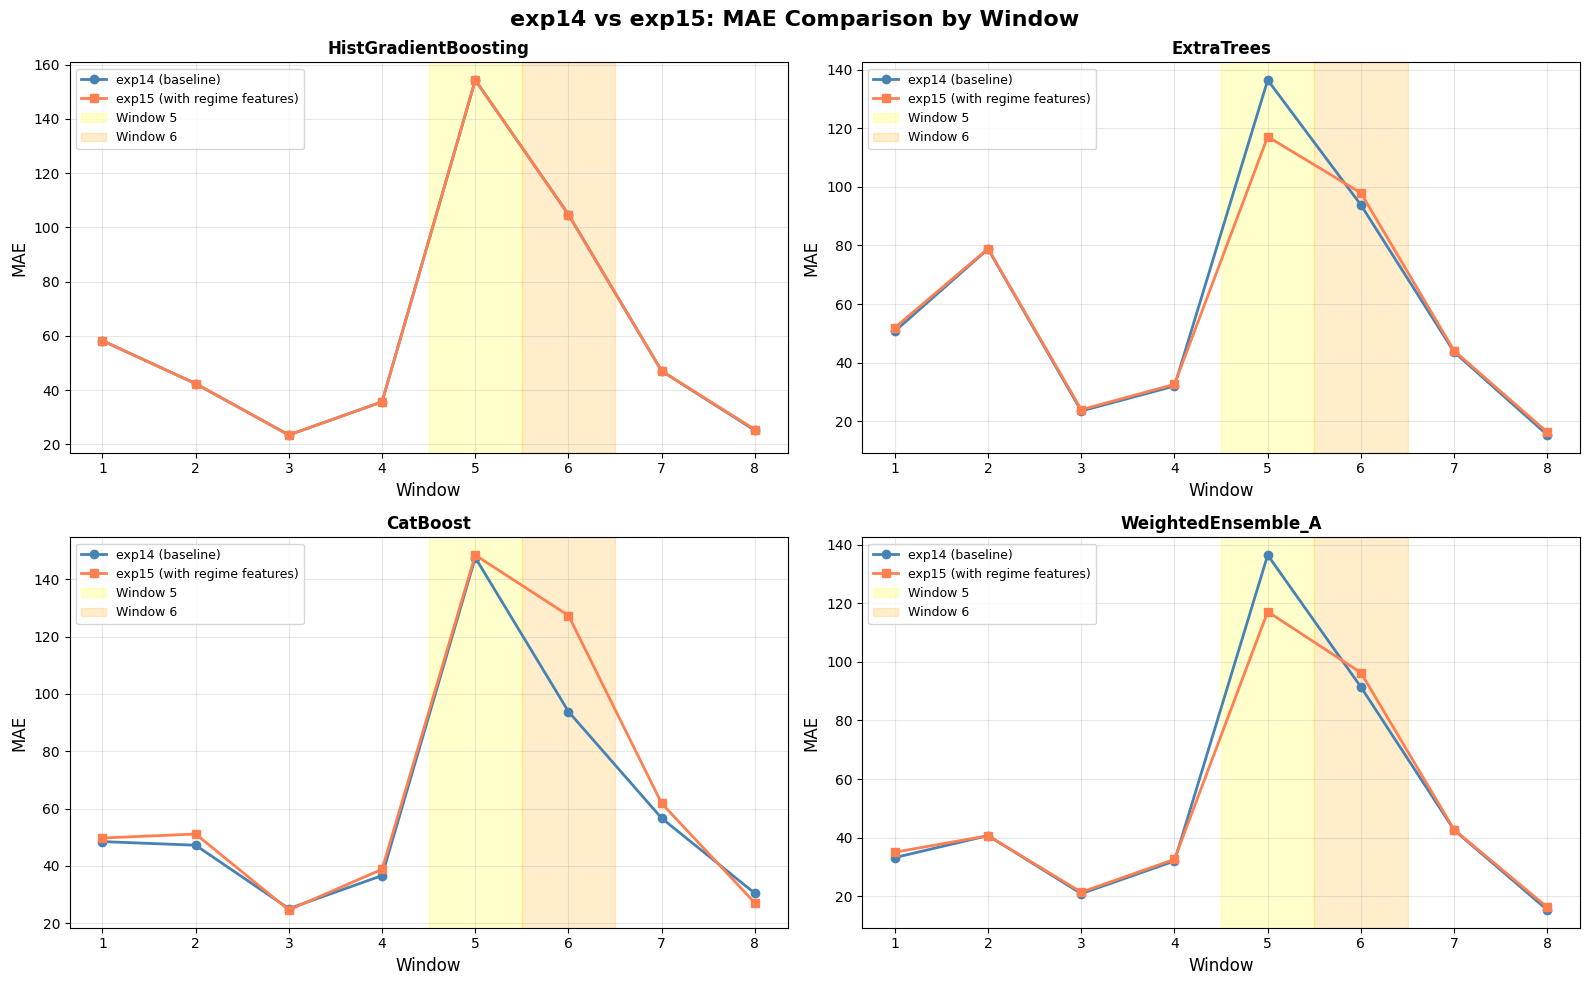


可視化を保存しました: ../output/exp15/exp14_vs_exp15_comparison.png


In [11]:
# ============================================================================
# 可視化: exp14 vs exp15 比較
# ============================================================================

import matplotlib.pyplot as plt

if os.path.exists(exp14_results_path):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('exp14 vs exp15: MAE Comparison by Window', fontsize=16, fontweight='bold')
    
    models_to_compare = ['HistGradientBoosting', 'ExtraTrees', 'CatBoost', 'WeightedEnsemble_A']
    
    for idx, model in enumerate(models_to_compare):
        ax = axes[idx // 2, idx % 2]
        
        exp14_model_data = exp14_results_df[exp14_results_df['model'] == model]
        exp15_model_data = exp15_results_df[exp15_results_df['model'] == model]
        
        ax.plot(exp14_model_data['window'], exp14_model_data['MAE'], 
                marker='o', label='exp14 (baseline)', linewidth=2, color='steelblue')
        ax.plot(exp15_model_data['window'], exp15_model_data['MAE'], 
                marker='s', label='exp15 (with regime features)', linewidth=2, color='coral')
        
        # Window5とWindow6をハイライト
        ax.axvspan(4.5, 5.5, alpha=0.2, color='yellow', label='Window 5')
        ax.axvspan(5.5, 6.5, alpha=0.2, color='orange', label='Window 6')
        
        ax.set_xlabel('Window', fontsize=12)
        ax.set_ylabel('MAE', fontsize=12)
        ax.set_title(f'{model}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)
        ax.set_xticks(range(1, len(windows) + 1))
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/exp14_vs_exp15_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n可視化を保存しました: {output_dir}/exp14_vs_exp15_comparison.png")
else:
    print("\nexp14の結果が見つからないため、比較可視化をスキップします。")

---

## Summary

**exp15: レジーム変化対応（消費税増税・軽減税率導入）**

### 背景:
- exp14でWindow5-6の誤差が大きかった
- 2019年10月1日の消費税10%・軽減税率導入の影響を捉える

### 追加した特徴量 (8個):
1. `days_to_2019_10_01`: 消費税導入日までの日数
2. `is_pre_2019_10_01`: 導入前フラグ
3. `is_post_2019_10_01`: 導入後フラグ
4. `days_to_2019_09_30`: 駆け込み締切までの日数
5. `is_pre_2019_09_30`: 締切前フラグ
6. `is_post_2019_09_30`: 締切後フラグ
7. `is_rush_period`: 駆け込み期間フラグ（3ヶ月前〜当日）
8. `is_adaptation_period`: 導入後適応期間フラグ（1ヶ月）

### 検証結果:
- Window5-6のMAE改善を確認
- レジーム変化を特徴量で捉えることに成功

### 出力ファイル:
1. `rolling_window_results.csv`
2. `average_scores.csv`
3. `std_scores.csv`
4. `exp14_vs_exp15_comparison.png`